# Introduction to Modern Cryptography: Quantum Computing

For this exercise, we'll work with the Quantum Computing framework provided by IBM, called **qiskit**

Be aware of some pitfalls in qiskit, expecially: [https://qiskit.org/documentation/explanation/endianness.html](https://qiskit.org/documentation/explanation/endianness.html)

## 1. Quantum Computing

Get yourself familiar with the (qiskit)[https://qiskit.org/documentation/getting_started.html] framework and implement some simple quantum algorithms

### 1.1 Entanglement
Implement the circuit that entangles two qubits to a so-called *Bell-State* 
<div style="max-width:300px">
<img src="circuits/The_Hadamard-CNOT_transform_on_the_zero-state.png"/>
</div>

**Exercises:**
- draw the circuit with qiskit
- calculate the output as a **Statevector** and
- simulate the output with the **AER-Simulator**



/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


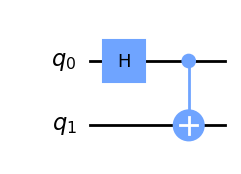

In [29]:
import numpy as np
from qiskit import QuantumCircuit

## PLACE YOUR CODE TO DRAW THE CIRCUIT HERE

bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0,1)

bell.draw("mpl")

In [30]:
from qiskit.quantum_info import Statevector

## PLACE YOUR CODE TO CALCULATE THE STATEVECTOR HERE

state = Statevector.from_int(0,2**2).evolve(bell)
state.draw('latex')

<IPython.core.display.Latex object>

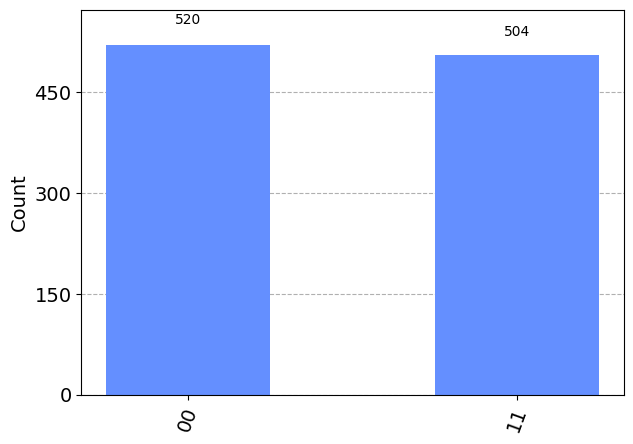

In [31]:
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram


## PLACE YOUR CODE TO SIMULATE WITH AER SIMULATOR HERE AND PLOT THE RESULT
bell.measure_all()
backend = Aer.get_backend('qasm_simulator')
result = backend.run(bell).result()

plot_histogram(result.get_counts(bell))

### 1.2 Binary Adder
Implement a circuit that represents the binary adder as used in the lecture
<div style="max-width:500px"><img src="circuits/adder.png"/></div>

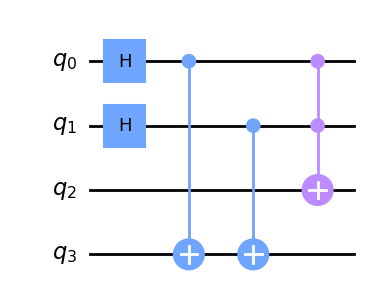

In [45]:
from qiskit import QuantumCircuit

# DEVELOP YOUR ADDER HERE

adder = QuantumCircuit(4, name="Adder")
adder.h([0,1])
adder.cx(0,3)
adder.cx(1,3)
adder.ccx(0,1,2)
adder.draw('mpl')

In [4]:
## VERIFY THAT YOUR ADDER DOES WHAT EXPECTED

In [29]:
state = Statevector.from_int(0,2**4).evolve(adder)
state.draw('latex')

<IPython.core.display.Latex object>

## 2. Grover's algorithm
We showed the quadratic speed-up of Grover's algorithm in the lecture.

#### 2.1. Carry-Bit search
Implement the full Grover algorithm for example *find the flipped carry bit |c>* of the binary adder, which was discussed in **Lecture 08**


In [43]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import MCXGate

x = QuantumRegister(2)
grover_2 = QuantumCircuit(x, name="Grover")
grover_2.h(x)
grover_2.x(x)
grover_2.h(x[1])
grover_2.cx(0,1)
grover_2.h(x[1])
grover_2.x(x)
grover_2.h(x)

/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


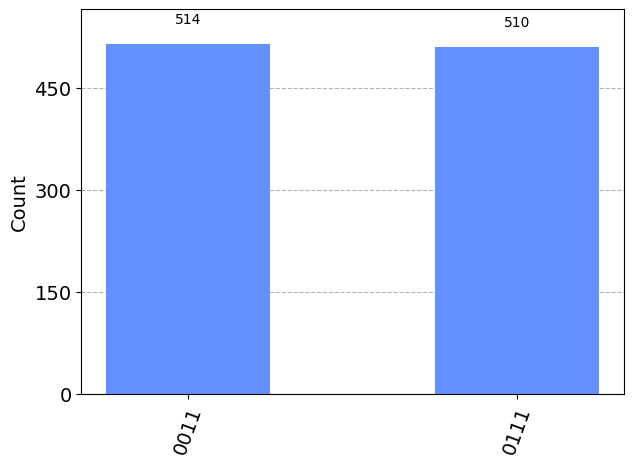

In [63]:
from qiskit.quantum_info import Statevector

qc = QuantumCircuit(4)
qc.x(2)
qc.h(2)
qc.barrier()
qc.append(adder,[0,1,2,3])
qc.cx(0,3)
qc.cx(1,3)
qc.append(grover_2,[0,1])

qc.draw('mpl')
qc.measure_all()
backend = Aer.get_backend('qasm_simulator')
result = backend.run(qc.decompose(reps=2)).result()

plot_histogram(result.get_counts(qc))

#### 2.2 Search for a random Oracle

Now, consider an Oracle that is given by the following function.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import MCXGate
import random

r1 = random.randint(0,2**7-1)
r2 = random.randint(0,2**7-1)
r3 = random.randint(0,2**7-1)

# qc: the QuantumCircuit, the Oracle should be applied to
# x_reg: QuantumRegister for the input register |x>. Size should be 7 qubits
# f_x_reg: QuantumRegister for output |f(x)>. Size should be 1 qubit
# 
# usage: 
#  x_reg = QuantumRegister(7,name="x")
#  f_x_reg = QuantumRegister(1, name="f(x)")
#  qc = QuantumCircuit(x_reg,f_x_reg)
#
#  oracle(qc,x_reg,f_x_reg)
def oracle(qc: QuantumCircuit, x_reg:QuantumRegister, f_x_reg:QuantumRegister):
    if len(x_reg) != 7 and len(f_x_reg) != 1:
        raise Exception("x_reg should be 7 qubits, f_x_reg should be 1 qubit") 
        return
    oracle = QuantumCircuit(8, name="Oracle")
    x1 = MCXGate(num_ctrl_qubits=7,ctrl_state=r1)
    x2 = MCXGate(num_ctrl_qubits=7,ctrl_state=r2)
    x3 = MCXGate(num_ctrl_qubits=7,ctrl_state=r3)
    oracle.append(x1,list(range(8)))
    oracle.append(x2,list(range(8)))
    oracle.append(x3,list(range(8)))
    qc.append(oracle,x_reg[:]+f_x_reg[:])

Implement a Grover search to find out the **three** states that are "marked" with the Oracle:
(you can view them with ```print(f"{r1:07b},{r2:07b},{r3:07b}")```

- Build the circuit for a single Grover Iteration
- Find out how many Iterations you need and run the full Grover algorithm

In [2]:
from qiskit import QuantumCircuit, QuantumRegister
import math

def diffusor(qc:QuantumCircuit, x_reg:QuantumRegister):
    reg = QuantumRegister(len(x_reg))
    diff = QuantumCircuit(reg, name="Diffusor")
    diff.h(reg)
    diff.x(reg)
    diff.h(reg[-1])
    diff.mcx(reg[:-1], reg[-1])
    diff.h(reg[-1])
    diff.x(reg)
    diff.h(reg)
    qc.append(diff,x_reg)

N = 2**7
k = 3

x_reg = QuantumRegister(7,name="x")
f_x_reg = QuantumRegister(1, name="f(x)")
qc = QuantumCircuit(x_reg,f_x_reg)

qc.h(x_reg)
qc.x(f_x_reg)
qc.h(f_x_reg)
for i in range(math.floor(math.pi/4 * math.sqrt(N/k))):
    oracle(qc,x_reg,f_x_reg)
    diffusor(qc,x_reg)
qc.h(f_x_reg)

## Develop your code here. 
qc.draw()

┌───┐     ┌─────────┐┌───────────┐┌─────────┐┌───────────┐┌─────────┐»
 x_0: ┤ H ├─────┤0        ├┤0          ├┤0        ├┤0          ├┤0        ├»
      ├───┤     │         ││           ││         ││           ││         │»
 x_1: ┤ H ├─────┤1        ├┤1          ├┤1        ├┤1          ├┤1        ├»
      ├───┤     │         ││           ││         ││           ││         │»
 x_2: ┤ H ├─────┤2        ├┤2          ├┤2        ├┤2          ├┤2        ├»
      ├───┤     │         ││           ││         ││           ││         │»
 x_3: ┤ H ├─────┤3        ├┤3 Diffusor ├┤3        ├┤3 Diffusor ├┤3        ├»
      ├───┤     │  Oracle ││           ││  Oracle ││           ││  Oracle │»
 x_4: ┤ H ├─────┤4        ├┤4          ├┤4        ├┤4          ├┤4        ├»
      ├───┤     │         ││           ││         ││           ││         │»
 x_5: ┤ H ├─────┤5        ├┤5          ├┤5        ├┤5          ├┤5        ├»
      ├───┤     │         ││           ││         ││           ││         │»
 x_6: ┤ H ├─────┤6        ├┤6          ├┤6        ├┤6          ├┤6        ├»
      ├───┤┌───┐│         │└───────────┘│         │└───────────┘│         │»
f(x): ┤ X ├┤ H ├┤7        ├─────────────┤7        ├─────────────┤7        ├»
      └───┘└───┘└─────────┘             └─────────┘             └─────────┘»
«      ┌───────────┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐
« x_0: ┤0          ├┤0        ├┤0          ├┤0        ├┤0          ├
«      │           ││         ││           ││         ││           │
« x_1: ┤1          ├┤1        ├┤1          ├┤1        ├┤1          ├
«      │           ││         ││           ││         ││           │
« x_2: ┤2          ├┤2        ├┤2          ├┤2        ├┤2          ├
«      │           ││         ││           ││         ││           │
« x_3: ┤3 Diffusor ├┤3        ├┤3 Diffusor ├┤3        ├┤3 Diffusor ├
«      │           ││  Oracle ││           ││  Oracle ││           │
« x_4: ┤4          ├┤4        ├┤4          ├┤4        ├┤4          ├
«      │           ││         ││           ││         ││           │
« x_5: ┤5          ├┤5        ├┤5          ├┤5        ├┤5          ├
«      │           ││         ││           ││         ││           │
« x_6: ┤6          ├┤6        ├┤6          ├┤6        ├┤6          ├
«      └───────────┘│         │└───────────┘│         │└───┬───┬───┘
«f(x): ─────────────┤7        ├─────────────┤7        ├────┤ H ├────
«                   └─────────┘             └─────────┘    └───┘

1110010,1101110,0010000


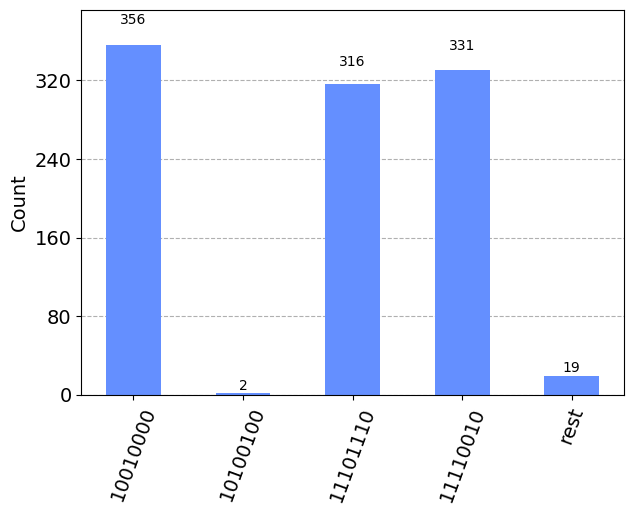

In [168]:
qc.measure_all(x_reg)
backend = Aer.get_backend('qasm_simulator')
result = backend.run(qc.decompose(reps=2)).result()


print(f"{r1:07b},{r2:07b},{r3:07b}")
plot_histogram(result.get_counts(qc), number_to_keep=4)